In [2]:
# Calling libraries:
from __future__ import division
%matplotlib inline
import numpy as np, time, matplotlib.pyplot as plt, math, pandas, numpy.random as npr, pystan as ps, pickle
from pylab import plot, show, legend
from time import time
from scipy.stats import *

In [2]:
sm = ps.StanModel(file="garch_WB.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f0ef85016fbe1114f4bfb9978c846a08 NOW.


In [3]:
T = 2000
p = 5
q = 3
r = max(p,q)
d = 10
y = np.zeros(T)
X = npr.randn(d,T)
omega = npr.rand()
beta = npr.rand(p)/p
alpha = npr.rand(q)/q
b = npr.randn(d)

In [4]:
sigsq = np.ones(T)
for t in np.arange(0,r) :
    y[t] = np.sqrt(sigsq[t])*npr.randn() + b.dot(X[:,t])
for t in np.arange(r,T) :
    sigsq[t] = omega + alpha.dot((y[t-q:t]-b.dot(X[:,t-q:t]))**2) + beta.dot(sigsq[t-p:t]) 
    y[t] = np.sqrt(sigsq[t])*npr.randn() + b.dot(X[:,t])

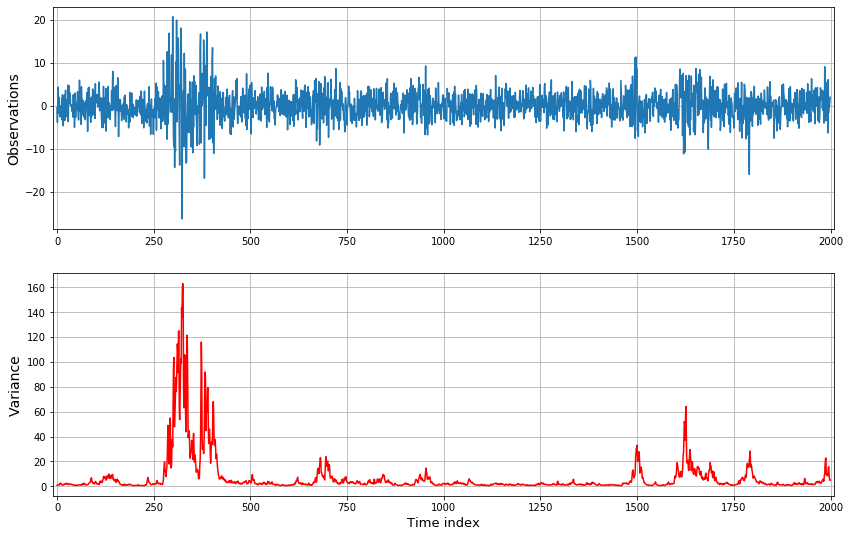

In [90]:
fig = plt.figure(figsize=(14,9))
plt.subplot(211)
plt.plot(y)
plt.xlim(-0.005*T,1.005*T)
plt.ylabel("Observations", fontsize=14)
plt.grid(True)
plt.subplot(212)
plt.plot(sigsq, color="red")
plt.xlim(-0.005*T,1.005*T)
plt.ylabel("Variance", fontsize=14)
plt.xlabel("Time index", fontsize=13)
plt.grid(True)
fig.savefig('garch_data.pdf', bbox_inches='tight', dpi=2000)

In [7]:
def acf(y, maxlag) :
    T = len(y)
    assert maxlag < T-10
    acfs = np.zeros(maxlag+1)
    for lag in range(maxlag+1) :
        y1 = y[0:(T-lag)]
        y2 = y[lag:T]
        acfs[lag] = (np.mean(y1*y2) - np.mean(y1)*np.mean(y2))/(np.std(y1)*np.std(y2))
    return acfs

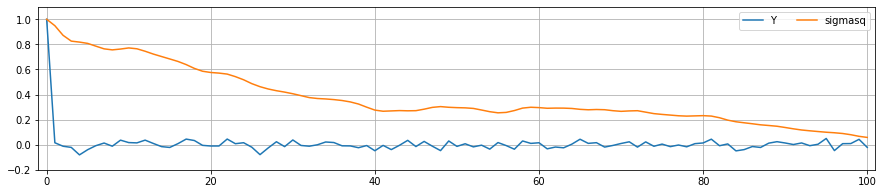

In [8]:
maxlag = 100
acfs_y = acf(y,maxlag)
acfs_sigsq = acf(sigsq,maxlag)
plt.figure(figsize=(15,3))
plt.plot(acfs_y, label="Y")
plt.plot(acfs_sigsq, label="sigmasq")
plt.grid(True)
plt.ylim(-0.2,1.1)
plt.legend(ncol=2)
plt.xlim(-0.01*maxlag,1.01*maxlag);

### MCMC on full dataset:

In [9]:
n_chains = 10

tstart, tend = 0, T
data = dict(T=tend-tstart, p=p, q=q, r=max(p,q), d=d, y=y[tstart:tend], X=X[:,tstart:tend], power=1)
start = time()
fit = sm.sampling(data=data, thin=1, n_jobs=min(10,n_chains), chains=n_chains, init="random", iter=500)
print(round((time()-start)/60,2), "minutes to run")

file = open("/xtmp/DC-BATS_data/garch/full_mcmc.pkl", "wb")
trace = fit.extract()
pickle.dump(fit.extract(), file)
file.close()

3.99 minutes to run


#### Get credible intervals:

In [10]:
file = open("/xtmp/DC-BATS_data/garch/full_mcmc.pkl", "rb")
trace = pickle.load(file)
file.close()

b_ci_full = np.percentile(trace['b'],axis=0,q=[2.5,97.5])
beta_ci_full = np.percentile(trace['beta'],axis=0,q=[2.5,97.5])
alpha_ci_full = np.percentile(trace['alpha'],axis=0,q=[2.5,97.5])
omega_ci_full = np.percentile(trace['omega'],axis=0,q=[2.5,97.5])

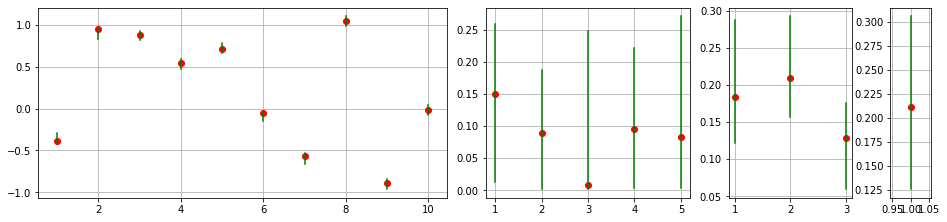

In [11]:
plt.rcParams['axes.grid'] = True
f, (a0, a1, a2, a3) = plt.subplots(1, 4, gridspec_kw={'width_ratios': [d, p, q, 1]}, figsize=(16,3.5))
b_ci = np.percentile(trace['b'],axis=0,q=[2.5,97.5])
a0.plot(np.arange(1,d+1), b, "ro")
for i in range(d) :
    a0.plot([i+1,i+1], b_ci_full[:,i], "g-")
a1.plot(np.arange(1,p+1), beta, "ro")
for i in range(p) :
    a1.plot([i+1,i+1], beta_ci_full[:,i], "g-")
a2.plot(np.arange(1,q+1), alpha, "ro")
for i in range(q) :
    a2.plot([i+1,i+1], alpha_ci_full[:,i], "g-")
a3.plot(1, omega, "ro")
a3.plot([1,1], omega_ci_full, "g-");

### Divide-and-conquer:

In [12]:
m = 10
tstarts = np.arange(m).astype(int)
tends = 1 + tstarts
tstarts *= int(T/m)
tends *= int(T/m)

In [13]:
for i in range(m) :
    tstart, tend = tstarts[i], tends[i]
    dict(T=tend-tstart, p=p, q=q, r=max(p,q), d=d, y=y[tstart:tend], X=X[:,tstart:tend], power=T/(tend-tstart))
    start = time()
    fit = sm.sampling(data=data, thin=1, n_jobs=min(10,n_chains), chains=n_chains, init="random", iter=500)
    print(round((time()-start)/60,2), "minutes to run chunk", i+1)
    file = open("/xtmp/DC-BATS_data/garch/mcmc_wb_chunk"+str(i+1)+".pkl", "wb")
    pickle.dump(fit.extract(), file)
    file.close()

4.33 minutes to run chunk 1


4.06 minutes to run chunk 2


3.92 minutes to run chunk 3


4.16 minutes to run chunk 4


3.72 minutes to run chunk 5


3.78 minutes to run chunk 6


3.98 minutes to run chunk 7


3.25 minutes to run chunk 8


RuntimeError: Initialization failed.

In [15]:
tstart, tend = tstarts[i], tends[i]
dict(T=tend-tstart, p=p, q=q, r=max(p,q), d=d, y=y[tstart:tend], X=X[:,tstart:tend], power=T/(tend-tstart))
start = time()
fit = sm.sampling(data=data, thin=1, n_jobs=min(10,n_chains), chains=n_chains, init="random", iter=500)
print(round((time()-start)/60,2), "minutes to run chunk", i+1)
file = open("/xtmp/DC-BATS_data/garch/mcmc_wb_chunk"+str(i+1)+".pkl", "wb")
pickle.dump(fit.extract(), file)
file.close()

3.23 minutes to run chunk 9


In [16]:
i = 9
tstart, tend = tstarts[i], tends[i]
dict(T=tend-tstart, p=p, q=q, r=max(p,q), d=d, y=y[tstart:tend], X=X[:,tstart:tend], power=T/(tend-tstart))
start = time()
fit = sm.sampling(data=data, thin=1, n_jobs=min(10,n_chains), chains=n_chains, init="random", iter=500)
print(round((time()-start)/60,2), "minutes to run chunk", i+1)
file = open("/xtmp/DC-BATS_data/garch/mcmc_wb_chunk"+str(i+1)+".pkl", "wb")
pickle.dump(fit.extract(), file)
file.close()

3.28 minutes to run chunk 10


#### Get credible intervals:

In [17]:
b_ci_dc = np.zeros((2,d))
beta_ci_dc = np.zeros((2,p))
alpha_ci_dc = np.zeros((2,q))
omega_ci_dc = np.zeros(2)
for i in range(m) :
    file = open("/xtmp/DC-BATS_data/garch/mcmc_wb_chunk"+str(i+1)+".pkl", "rb")
    trace = pickle.load(file)
    b_ci_dc += np.percentile(trace['b'],axis=0,q=[2.5,97.5])/m
    beta_ci_dc += np.percentile(trace['beta'],axis=0,q=[2.5,97.5])/m
    alpha_ci_dc += np.percentile(trace['alpha'],axis=0,q=[2.5,97.5])/m
    omega_ci_dc += np.percentile(trace['omega'],axis=0,q=[2.5,97.5])/m

### Compare credible intervals:

In [1]:
fig = plt.figure(figsize=(16,3.5))
plt.rcParams['axes.grid'] = True
f, (a0, a1, a2, a3) = plt.subplots(1, 4, gridspec_kw={'width_ratios': [d, p, q, 1]}, figsize=(16,3.5))
a0.plot(np.arange(1,d+1), b, "ro")
for i in range(d) :
    a0.plot([i+0.9,i+0.9], b_ci_dc[:,i], "b-")
    a0.plot([i+1.1,i+1.1], b_ci_full[:,i], "g-")
a0.axis(xmin=0,xmax=d+1)
a1.plot(np.arange(1,p+1), beta, "ro")
for i in range(p) :
    a1.plot([i+0.9,i+0.9], beta_ci_dc[:,i], "b-")
    a1.plot([i+1.1,i+1.1], beta_ci_full[:,i], "g-")
a1.axis(xmin=0,xmax=p+1)
a2.plot(np.arange(1,q+1), alpha, "ro")
for i in range(q) :
    a2.plot([i+0.9,i+0.9], alpha_ci_dc[:,i], "b-")
    a2.plot([i+1.1,i+1.1], alpha_ci_full[:,i], "g-")
a2.axis(xmin=0,xmax=q+1)
a3.plot(1, omega, "ro")
a3.plot([0.9,0.9], omega_ci_dc, "b-", label="Divide-and-conquer")
a3.plot([1.1,1.1], omega_ci_full, "g-", label="MCMC on full data")
a3.axis(xmin=0,xmax=2)
plt.text(x=-32, y=0.33, s=r"$b$", fontsize=13)
plt.text(x=-15, y=0.33, s=r"$\beta$", fontsize=13)
plt.text(x=-5, y=0.33, s=r"$\alpha$", fontsize=13)
plt.text(x=0.6, y=0.33, s=r"$\omega$", fontsize=13)
plt.text(x=-25, y=0.35, s=r"Credible intervals", fontsize=14)
plt.legend(ncol=2, loc=(-6,1.15))
f.savefig('garch_CI.pdf', bbox_inches='tight', dpi=2000)

NameError: name 'plt' is not defined

In [ ]:
print(np.mean(b_ci_dc[1]-b_ci_dc[0])/np.mean(b_ci_full[1]-b_ci_full[0]))
print(np.mean(beta_ci_dc[1]-beta_ci_dc[0])/np.mean(beta_ci_full[1]-beta_ci_full[0]))
print(np.mean(alpha_ci_dc[1]-alpha_ci_dc[0])/np.mean(alpha_ci_full[1]-alpha_ci_full[0]))

In [14]:
1

1